In [3]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
from dm21cm.data_loader import load_data
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges

sys.path.append(os.environ['DH_DIR'])
import darkhistory
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702


In [4]:
print(darkhistory.__version__)

1.0.0-dm21cm.0


## dm21cm

In [5]:
dep_tf = load_data(
    'phot_dep',
    prefix=os.environ['DM21CM_DATA_DIR'] + '/tf/230408x/phot',
    reload=True
)

INFO:root:Loaded photon deposition transfer function.


### dm21cm: 1 photon

In [13]:
spec_N = np.zeros((500,))
spec_N[300] = 1.
photeng = dep_tf.abscs['Ein']
print(f'total energy = {np.dot(spec_N, photeng)}')

total energy = 1158962.0723298236


In [14]:
rs_grid = np.geomspace(5, 50, 10)
#rs = np.sqrt(rs_grid[-2]*rs_grid[-3])
rs_start = rs_grid[8]
rs_end = rs_start / 1.05
xe = 0.001
print(rs_start)

38.71318413405634


In [20]:
dm21cm_dep = dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs_start,
    nBs_s = jnp.array([1.]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / np.dot(spec_N, photeng) / (0.04879016/0.001)

dm21cm_dep = np.array(dm21cm_dep).flatten()

## DH

In [21]:
soln = dh_evolve(
    DM_process='swave', mDM=photeng[301], sigmav=1e-23, primary='phot_delta',
    start_rs=rs_start, end_rs=rs_start/1.001**2,
    coarsen_factor=1, backreaction=True, 
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    debug=True
)

Loading time: 0.000 s
Initialization time: 0.023 s
0 rs=38.713
1 rs=38.674
Main loop time: 0.052 s


In [22]:
dh_dep = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
dh_dep = dh_dep[:,1]

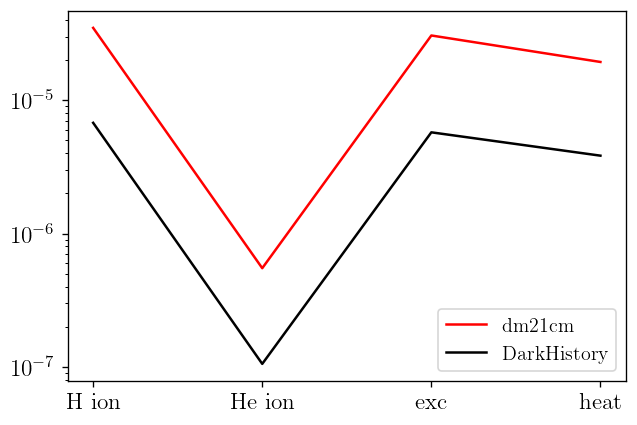

In [24]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()
ax.plot(dm21cm_dep[:4], label='dm21cm', color='r')
ax.plot(dh_dep[:4], label='DarkHistory', color='k')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

In [25]:
dm21cm_dep[:4] / dh_dep[:4]

array([5.16169468, 5.22770238, 5.33356603, 5.05137835])

## loop over rs

In [27]:
f_ratios_arr = []

for rs in tqdm(np.geomspace(5, 50, 100)):
    rs_start = rs
    rs_end = rs_start / 1.05
    xe = 0.001
    dm21cm_dep = dep_tf(
        in_spec = spec_N,
        sum_result = False,
        rs = rs_start,
        nBs_s = jnp.array([1.]),
        x_s = jnp.array([xe]),
        out_of_bounds_action = 'clip',
    ) / np.dot(spec_N, photeng) / (0.04879016/0.001)

    dm21cm_dep = np.array(dm21cm_dep).flatten()

    soln = dh_evolve(
        DM_process='swave', mDM=photeng[301], sigmav=1e-20, primary='phot_delta',
        start_rs=rs_start, end_rs=rs_start/1.001**3,
        coarsen_factor=1, backreaction=True, 
        struct_boost=lambda rs: 1.,
        init_cond=(xe, phys.chi*xe, 10*phys.kB),
        use_tqdm=False, verbose=0
    )

    dh_dep = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
    dh_dep = dh_dep[:,1]

    f_ratios_arr.append(dm21cm_dep[:4]/dh_dep[:4])
    
f_ratios_arr = np.array(f_ratios_arr)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.36it/s]


In [28]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

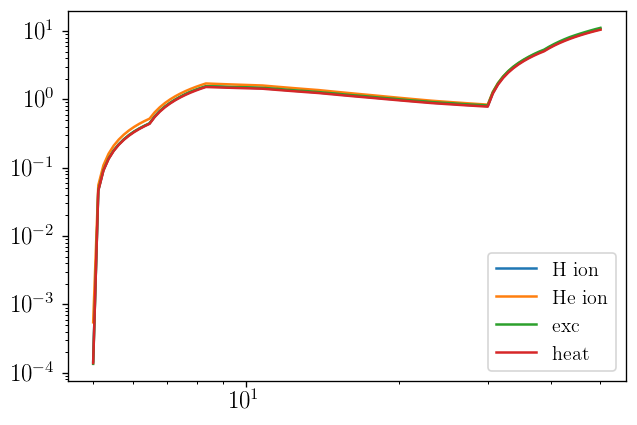

In [30]:
fig, ax = plt.subplots()

rs_arr = np.geomspace(5, 50, 100)
ax.plot(rs_arr, f_ratios_arr[:, 0], label='H ion')
ax.plot(rs_arr, f_ratios_arr[:, 1], label='He ion')
ax.plot(rs_arr, f_ratios_arr[:, 2], label='exc')
ax.plot(rs_arr, f_ratios_arr[:, 3], label='heat')

ax.legend()
ax.set(yscale='log')
ax.set(xscale='log');

## Strategy: let DH output tf values

In [115]:
rs_start = rs_grid[-2]
xe = 0.001
print(rs_start)

38.71318413405634


In [116]:
soln = dh_evolve(
    DM_process='swave', mDM=photeng[301], sigmav=1e-20, primary='phot_delta',
    start_rs=rs_start, end_rs=rs_start/1.001**3,
    coarsen_factor=1, backreaction=True, 
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    debug=True
)

Loading time: 0.000 s
Initialization time: 0.020 s
0 rs=38.713
1 rs=38.674
2 rs=38.636
Main loop time: 0.087 s


In [117]:
f_dh = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
f_dh = f_dh[:,1]

In [118]:
spec_N = np.zeros((500,))
spec_N[300] = 1.

f_dm21cm = dep_tf(
    in_spec = spec_N,
    sum_result = False,
    rs = rs_start,
    nBs_s = jnp.array([1.]),
    x_s = jnp.array([xe]),
    out_of_bounds_action = 'clip',
) / np.dot(spec_N, photeng) / (0.04879016/0.001)
f_dm21cm = np.array(f_dm21cm).flatten()

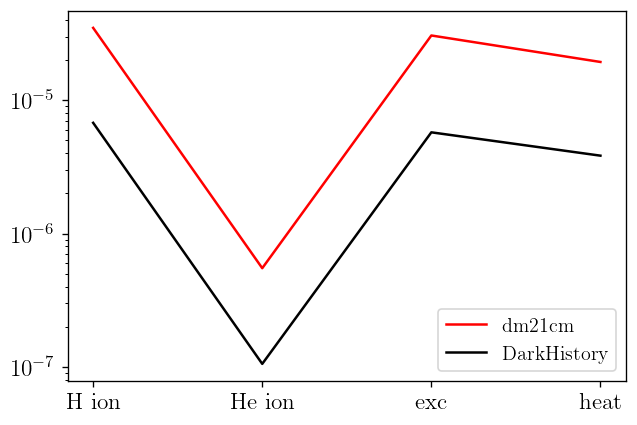

In [119]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()
ax.plot(f_dm21cm[:4], label='dm21cm', color='r')
ax.plot(f_dh[:4], label='DarkHistory', color='k')
ax.set_xticks(np.arange(4))
ax.set_xticklabels([s.decode('utf-8') for s in dep_tf.abscs['out'][:4]])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

In [120]:
f_dm21cm[:4]/f_dh[:4]

array([5.16169468, 5.22770238, 5.33356603, 5.05137835])

## compare HED tf

In [121]:
hed_dh = soln['debug'][1]['hed']

In [122]:
hed_dh

array([ 1.49291640e-12,  1.17544497e-12,  3.57459190e-14, -7.41452588e-15])

In [123]:
from darkhistory.config import load_data as dh_load_data

In [124]:
dh_dep_tf = dh_load_data('dep_tf')
dh_hed_tf = dh_dep_tf['highengdep']

In [125]:
dh_hed_tf.get_val(xe, phys.chi*xe, rs_start)[300]

array([ 1.49640502e-12,  1.17832492e-12,  3.88089232e-14, -7.44093853e-15])

In [131]:
hdul = fits.open('../tf_z_3.871E+01_x_1.000E-03_nBs_1.006E+00.fits')

In [132]:
hed_dm21cm = hdul[1].data['HED_TF'][0,300]
hed_dm21cm

array([ 1.33635997e-12,  1.05298514e-12,  3.68787233e-14, -6.33108720e-15])

In [133]:
hed_dm21cm / hed_dh

array([0.89513382, 0.89581832, 1.03169045, 0.8538762 ])

In [ ]:
# idl n=1.000
array([ 1.32418559e-12,  1.04332344e-12,  3.65378420e-14, -6.30489835e-15])

In [ ]:
# idl n=1.006

# 3. f

In [52]:
rs = rs_grid[-2]
rs_start = rs
xe = 0.001
print(rs_start)

38.71318413405634


## 3.1 DH soln f

In [53]:
soln = dh_evolve(
    DM_process='swave', mDM=photeng[301], sigmav=1e-20, primary='phot_delta',
    start_rs=rs_start, end_rs=rs_start/1.001**3,
    coarsen_factor=1, backreaction=True, 
    struct_boost=lambda rs: 1.,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=0,
    debug=True
)

In [54]:
f_dh = np.array([soln['f']['low'][k] + soln['f']['high'][k] for k in soln['f']['low']])
f_dh = f_dh[:,1]
print(f_dh)

[6.77732039e-06 1.05066765e-07 5.75031585e-06 3.84128932e-06
 1.00710943e-06]


## 3.2 Manual DH

In [45]:
from darkhistory.low_energy.lowE_electrons import make_interpolator
from darkhistory.low_energy.lowE_deposition import compute_fs
from darkhistory.config import load_data as dh_load_data

from dm21cm.utils import load_dict

In [35]:
MEDEA_interp = make_interpolator(interp_type='2D', cross_check=False)

In [42]:
abscs = load_dict(f"../../data/abscissas/abscs_230408x.h5")

In [43]:
photeng = abscs['photE']
eleceng = abscs['elecEk']

In [57]:
lep_tf = dh_load_data('dep_tf')['lowengphot'].get_tf(xe, phys.chi*xe, rs)
lee_tf = dh_load_data('dep_tf')['lowengelec'].get_tf(xe, phys.chi*xe, rs)
hed_tf = dh_load_data('dep_tf')['highengdep'].get_val(xe, phys.chi*xe, rs)

In [67]:
struct_boost = lambda x: 1.
rate_func_N = lambda x: 1.
rate_func_eng = lambda x: photeng[300]

In [61]:
import darkhistory.physics as phys

In [62]:
dlnz = 0.001
start_rs = rs
dt = dlnz * 1 / phys.hubble(rs)

def norm_fac(rs):
    # Normalization to convert from per injection event to 
    # per baryon per dlnz step. 
    return rate_func_N(rs) * (
        dlnz * 1 / phys.hubble(rs) / (phys.nB * rs**3)
    )

def rate_func_eng_unclustered(rs):
    return rate_func_eng(rs)

In [63]:
in_spec_phot_N = np.zeros((500,))
in_spec_phot_N[300] = 1.
in_spec_phot = Spectrum(photeng, in_spec_phot_N, spec_type='N', rs=rs)

lowengphot_spec_at_rs  = Spectrum(photeng, lep_tf.grid_vals[300], spec_type='N', rs=rs) * norm_fac(rs)
lowengelec_spec_at_rs  = Spectrum(eleceng, lee_tf.grid_vals[300], spec_type='N', rs=rs) * norm_fac(rs)
highengdep_at_rs       = hed_tf[300] * norm_fac(rs)

In [65]:
x_vec_for_f = np.array([1-xe, phys.chi*(1-xe), phys.chi*xe])

In [68]:
f_raw = compute_fs(
    MEDEA_interp, lowengelec_spec_at_rs, lowengphot_spec_at_rs,
    x_vec_for_f, rate_func_eng_unclustered(rs), dt,
    highengdep_at_rs, method='no_He', cross_check=False
)
fs = np.sum(f_raw, axis=0)

In [69]:
fs

array([6.76041712e-06, 1.04900712e-07, 5.73618417e-06, 3.83615518e-06,
       1.00547641e-06])

## 3.3 phot_depgv

In [73]:
f_phot_depgv = np.array([3.02620381e-04, 4.91613873e-06,
                         2.57787009e-04, 1.80138647e-04, 4.73036216e-05])

## 3.4 phot_dep.h5

In [82]:
f_phot_dep = np.array([350.7255435,5.69761833,298.76536614,208.77385962,54.82310326]) / photeng[300]

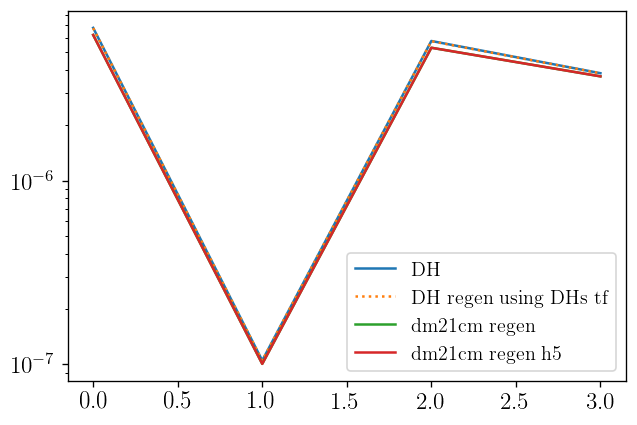

In [83]:
plt.plot(f_dh[:4], label='DH')
plt.plot(fs[:4], ls=':', label='DH regen using DHs tf')
plt.plot(f_phot_depgv[:4]/(0.04879016/0.001), label='dm21cm regen')
plt.plot(f_phot_dep[:4]/(0.04879016/0.001), label='dm21cm regen h5')
plt.legend()
plt.yscale('log')

## depgv

In [11]:
photeng = dep_tf.abscs['Ein']

In [12]:
np.array([3.02620381e-04, 4.91613873e-06, 2.57787009e-04, 1.80138647e-04, 4.73036216e-05]) / photeng[300]

array([2.61113274e-10, 4.24184609e-12, 2.22429202e-10, 1.55431011e-10,
       4.08155044e-11])

## tmp

In [9]:
dep_tf.abscs['nBs'][6]

1.006

### whether interp is good

In [75]:
dh_hed_tf.rs[0]

array([ 4.        ,  4.56626611,  5.21269655,  5.9506399 ,  6.79305133,
        7.75472002,  8.85252881, 10.10575058, 11.5363866 , 13.16955279,
       15.03392065, 17.1622206 , 19.59181658, 22.36536203, 25.53154867,
       29.14596137, 33.27205392, 37.98226307, 43.35928017, 49.49750292])

In [72]:
dh_hed_tf.grid_vals[0][0,0,:,300,0]

array([4.64187033e-15, 6.56835553e-15, 9.28174429e-15, 1.30984713e-14,
       1.84602453e-14, 2.59829472e-14, 3.65242104e-14, 5.12769460e-14,
       7.18984137e-14, 1.00688250e-13, 1.40833838e-13, 1.96747688e-13,
       2.74531522e-13, 3.82612848e-13, 5.32618476e-13, 7.40569560e-13,
       1.02851857e-12, 1.42678247e-12, 1.97699157e-12, 2.73624409e-12])

[]

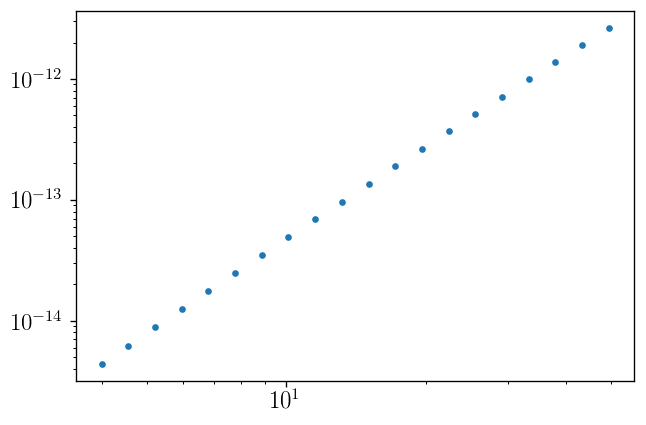

In [89]:
plt.plot(dh_hed_tf.rs[0], dh_hed_tf.grid_vals[0][1,1,:,300,0], '.')
plt.loglog()

# Appendix

### dm21cm: DM

In [35]:
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
)

In [36]:
z_edges = get_z_edges(44, 6, 1.05)

In [37]:
z_early, z_late, z_mid = z_edges[3], z_edges[4], np.sqrt(z_edges[3]*z_edges[4])

In [38]:
z_mid

36.68125290890279

In [40]:
dt = phys.dt_between_z(z_early, z_late)
n_Bavg = phys.n_B * (1+z_mid)**3 # [Bavg cm^-3]
delta_box = 0.
struct_boost = 1.
rho_DM_box = (1 + delta_box) * phys.rho_DM * (1+z_mid)**3 # [eV cm^-3]
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * struct_boost / n_Bavg
dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box)
dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / struct_boost

In [41]:
dE_inj_per_Bavg_unclustered

0.05832310611619097

In [42]:
records = np.load("../../data/run_info/phph_dhinit_s8zero_records.npy", allow_pickle=True).item()

In [43]:
x_e = interpolate.interp1d(records['z'], records['x_e'])(z_mid).item()

In [44]:
x_e

0.006042476201550739

In [47]:
inj_per_Bavg_box

2.916155305809549e-12

In [48]:
dep_tf(in_spec=dm_params.inj_phot_spec.N, sum_result=False, rs = 1+z_mid,
       nBs_s = jnp.array([1.]),
       x_s = jnp.array([x_e]),
       out_of_bounds_action = 'clip',) * inj_per_Bavg_box / dE_inj_per_Bavg_unclustered

Array([[4.6513392e-08, 7.2935558e-10, 3.9496822e-08, 4.0667299e-08,
        6.2892513e-09, 1.2869677e-04]], dtype=float32)